# Imports

In [1]:
import pandas as pd
import numpy as np
from numpy import isnan
import matplotlib.pyplot as plt
import seaborn as sns
import os

pd.set_option('display.max_columns', None)
from pandas.api.types import is_numeric_dtype


#  Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from xgboost import XGBClassifier
import xgboost as xgb


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.impute import KNNImputer


# Data Gathering

In [2]:
df = pd.read_csv("../Resources/healthcare-dataset-stroke-data.csv")  #,na_values='Unknown')
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [3]:
smokers_grouped = df.groupby("smoking_status")["id"].count()
smokers_grouped.head(10)

smoking_status
Unknown            1544
formerly smoked     885
never smoked       1892
smokes              789
Name: id, dtype: int64

In [4]:
work_type_grouped = df.groupby("work_type")["id"].count()
work_type_grouped.head(10)

work_type
Govt_job          657
Never_worked       22
Private          2925
Self-employed     819
children          687
Name: id, dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


# Data Manipulation/Cleaning

In [6]:
# Delete 1 "other" gender
df = df.loc[df["gender"] != "Other"]

df.shape

(5109, 12)

In [7]:
# impute Nulls with mean/mode  
df.bmi.fillna(df.bmi.mean(), inplace=True)
    

C:\Users\chuck\anaconda4\envs\tf-env\lib\site-packages\pandas\core\series.py:4469: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [8]:
    # Substitute 1/0 for yes / no and rural / urban 

df["Sex_Label"] = [1 if x == "Male" else 0 for x in df.gender] #label encoding
df.drop("gender", axis=1, inplace=True)

df["Married_Label"] = [1 if x == "Yes" else 0 for x in df.ever_married] #label encoding
df.drop("ever_married", axis=1, inplace=True)

df["Residence_Label"] = [1 if x == "Rural" else 0 for x in df.Residence_type] #label encoding
df.drop("Residence_type", axis=1, inplace=True)

  

C:\Users\chuck\anaconda4\envs\tf-env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\chuck\anaconda4\envs\tf-env\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\chuck\anaconda4\envs\tf-env\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [9]:
df

,id,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,smoking_status,stroke,Sex_Label,Married_Label,Residence_Label
0,9046,67.0,0,1,Private,228.69,36.60000,formerly smoked,1,1,1,0
1,51676,61.0,0,0,Self-employed,202.21,28.89456,never smoked,1,0,1,1
2,31112,80.0,0,1,Private,105.92,32.50000,never smoked,1,1,1,1
3,60182,49.0,0,0,Private,171.23,34.40000,smokes,1,0,1,0
4,1665,79.0,1,0,Self-employed,174.12,24.00000,never smoked,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,80.0,1,0,Private,83.75,28.89456,never smoked,0,0,1,0
5106,44873,81.0,0,0,Self-employed,125.20,40.00000,never smoked,0,0,1,0
5107,19723,35.0,0,0,Self-employed,82.99,30.60000,never smoked,0,0,1,1
5108,37544,51.0,0,0,Private,166.29,25.60000,formerly smoked,0,1,1,1


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5109 non-null   int64  
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   work_type          5109 non-null   object 
 5   avg_glucose_level  5109 non-null   float64
 6   bmi                5109 non-null   float64
 7   smoking_status     5109 non-null   object 
 8   stroke             5109 non-null   int64  
 9   Sex_Label          5109 non-null   int64  
 10  Married_Label      5109 non-null   int64  
 11  Residence_Label    5109 non-null   int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 518.9+ KB


In [11]:
#Split out work_type and smoking_status using get dummies

linear_dums = pd.get_dummies(df[["work_type", "smoking_status"]], drop_first=False) #linear models don't need the extra column
tree_dums = pd.get_dummies(df[["work_type", "smoking_status"]], drop_first=False)



In [12]:
linear_dums

,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0,0,1,0,0,0,1,0,0
1,0,0,0,1,0,0,0,1,0
2,0,0,1,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,1
4,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
5105,0,0,1,0,0,0,0,1,0
5106,0,0,0,1,0,0,0,1,0
5107,0,0,0,1,0,0,0,1,0
5108,0,0,1,0,0,0,1,0,0


In [13]:
tree_dums

,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0,0,1,0,0,0,1,0,0
1,0,0,0,1,0,0,0,1,0
2,0,0,1,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,1
4,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
5105,0,0,1,0,0,0,0,1,0
5106,0,0,0,1,0,0,0,1,0
5107,0,0,0,1,0,0,0,1,0
5108,0,0,1,0,0,0,1,0,0


In [14]:
# Combine back into the training set
df_train_linear = pd.concat([df[["age", "hypertension", "heart_disease", "avg_glucose_level", "bmi", "stroke", "Sex_Label","Married_Label","Residence_Label"]], linear_dums], axis=1)
df_train_tree = pd.concat([df[["age", "hypertension", "heart_disease", "avg_glucose_level", "bmi", "stroke", "Sex_Label","Married_Label","Residence_Label"]], tree_dums], axis=1)


In [15]:
# rename fields with bad syntax
df_train_linear = df_train_linear.rename({'work_type_Self-employed': 'work_type_self_employed', 'smoking_status_formerly smoked': 'smoking_status_formerly_smoked', 'smoking_status_never smoked':'smoking_status_never_smoked'}, axis=1)
df_train_tree = df_train_tree.rename({'work_type_Self-employed': 'work_type_self_employed', 'smoking_status_formerly smoked': 'smoking_status_formerly_smoked', 'smoking_status_never smoked':'smoking_status_never_smoked'}, axis=1)



In [16]:
df_train_linear

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,Sex_Label,Married_Label,Residence_Label,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_self_employed,work_type_children,smoking_status_Unknown,smoking_status_formerly_smoked,smoking_status_never_smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.60000,1,1,1,0,0,0,1,0,0,0,1,0,0
1,61.0,0,0,202.21,28.89456,1,0,1,1,0,0,0,1,0,0,0,1,0
2,80.0,0,1,105.92,32.50000,1,1,1,1,0,0,1,0,0,0,0,1,0
3,49.0,0,0,171.23,34.40000,1,0,1,0,0,0,1,0,0,0,0,0,1
4,79.0,1,0,174.12,24.00000,1,0,1,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,80.0,1,0,83.75,28.89456,0,0,1,0,0,0,1,0,0,0,0,1,0
5106,81.0,0,0,125.20,40.00000,0,0,1,0,0,0,0,1,0,0,0,1,0
5107,35.0,0,0,82.99,30.60000,0,0,1,1,0,0,0,1,0,0,0,1,0
5108,51.0,0,0,166.29,25.60000,0,1,1,1,0,0,1,0,0,0,1,0,0


In [17]:
df_train_linear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5109 non-null   float64
 1   hypertension                    5109 non-null   int64  
 2   heart_disease                   5109 non-null   int64  
 3   avg_glucose_level               5109 non-null   float64
 4   bmi                             5109 non-null   float64
 5   stroke                          5109 non-null   int64  
 6   Sex_Label                       5109 non-null   int64  
 7   Married_Label                   5109 non-null   int64  
 8   Residence_Label                 5109 non-null   int64  
 9   work_type_Govt_job              5109 non-null   uint8  
 10  work_type_Never_worked          5109 non-null   uint8  
 11  work_type_Private               5109 non-null   uint8  
 12  work_type_self_employed         51

In [18]:
df_train_linear

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,Sex_Label,Married_Label,Residence_Label,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_self_employed,work_type_children,smoking_status_Unknown,smoking_status_formerly_smoked,smoking_status_never_smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.60000,1,1,1,0,0,0,1,0,0,0,1,0,0
1,61.0,0,0,202.21,28.89456,1,0,1,1,0,0,0,1,0,0,0,1,0
2,80.0,0,1,105.92,32.50000,1,1,1,1,0,0,1,0,0,0,0,1,0
3,49.0,0,0,171.23,34.40000,1,0,1,0,0,0,1,0,0,0,0,0,1
4,79.0,1,0,174.12,24.00000,1,0,1,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,80.0,1,0,83.75,28.89456,0,0,1,0,0,0,1,0,0,0,0,1,0
5106,81.0,0,0,125.20,40.00000,0,0,1,0,0,0,0,1,0,0,0,1,0
5107,35.0,0,0,82.99,30.60000,0,0,1,1,0,0,0,1,0,0,0,1,0
5108,51.0,0,0,166.29,25.60000,0,1,1,1,0,0,1,0,0,0,1,0,0


In [19]:
df_train_tree

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,Sex_Label,Married_Label,Residence_Label,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_self_employed,work_type_children,smoking_status_Unknown,smoking_status_formerly_smoked,smoking_status_never_smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.60000,1,1,1,0,0,0,1,0,0,0,1,0,0
1,61.0,0,0,202.21,28.89456,1,0,1,1,0,0,0,1,0,0,0,1,0
2,80.0,0,1,105.92,32.50000,1,1,1,1,0,0,1,0,0,0,0,1,0
3,49.0,0,0,171.23,34.40000,1,0,1,0,0,0,1,0,0,0,0,0,1
4,79.0,1,0,174.12,24.00000,1,0,1,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,80.0,1,0,83.75,28.89456,0,0,1,0,0,0,1,0,0,0,0,1,0
5106,81.0,0,0,125.20,40.00000,0,0,1,0,0,0,0,1,0,0,0,1,0
5107,35.0,0,0,82.99,30.60000,0,0,1,1,0,0,0,1,0,0,0,1,0
5108,51.0,0,0,166.29,25.60000,0,1,1,1,0,0,1,0,0,0,1,0,0


In [20]:
df_train_tree.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5109 non-null   float64
 1   hypertension                    5109 non-null   int64  
 2   heart_disease                   5109 non-null   int64  
 3   avg_glucose_level               5109 non-null   float64
 4   bmi                             5109 non-null   float64
 5   stroke                          5109 non-null   int64  
 6   Sex_Label                       5109 non-null   int64  
 7   Married_Label                   5109 non-null   int64  
 8   Residence_Label                 5109 non-null   int64  
 9   work_type_Govt_job              5109 non-null   uint8  
 10  work_type_Never_worked          5109 non-null   uint8  
 11  work_type_Private               5109 non-null   uint8  
 12  work_type_self_employed         51

## Data Cleanup / Scaling


In [21]:
#x_scaler = MinMaxScaler()


In [22]:
#features = df
#x_scaler.fit(features)

# Data Exploration

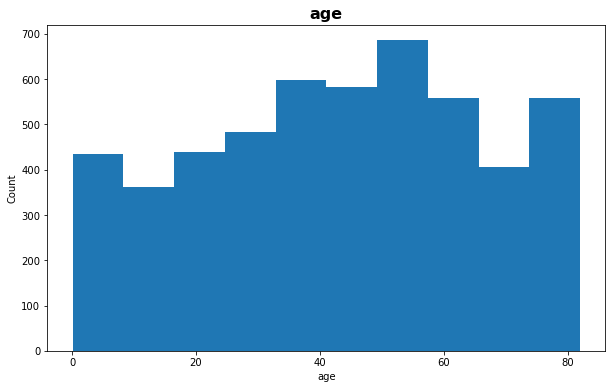

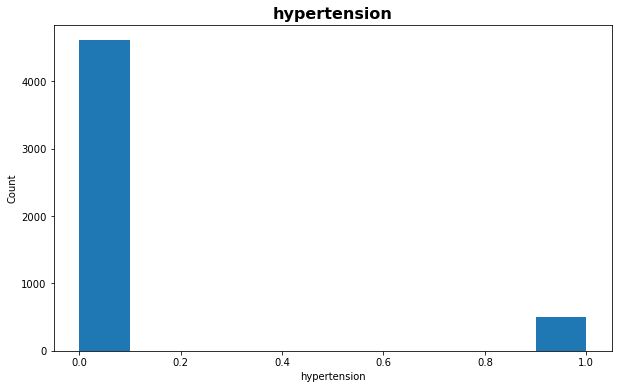

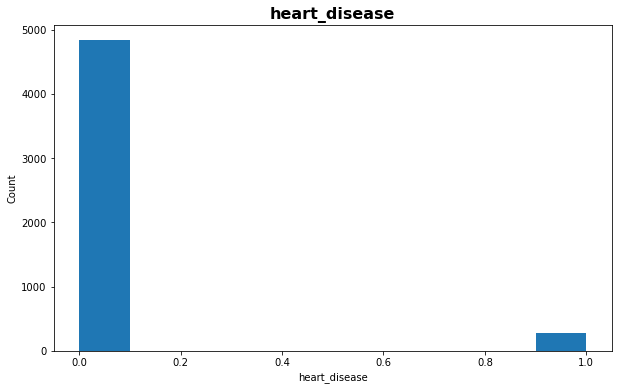

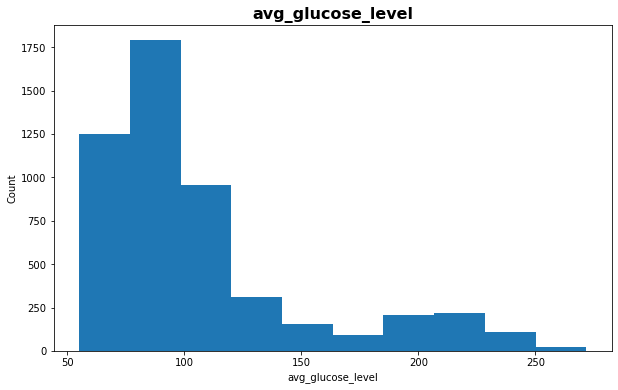

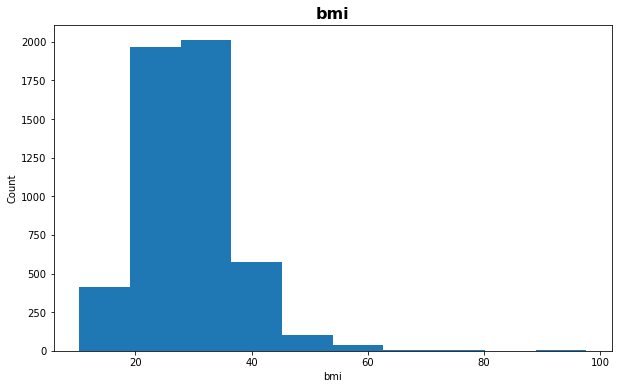

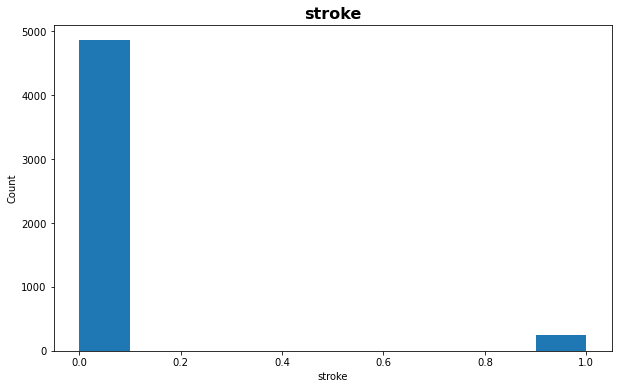

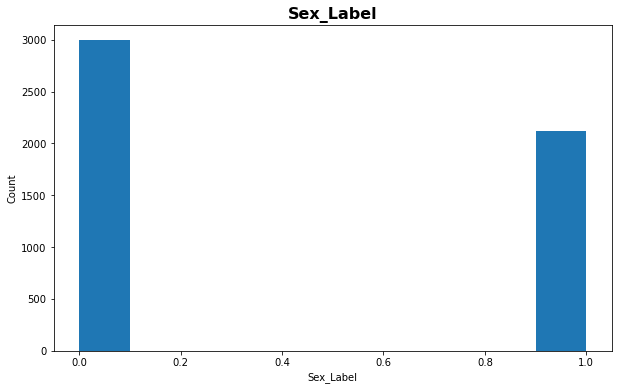

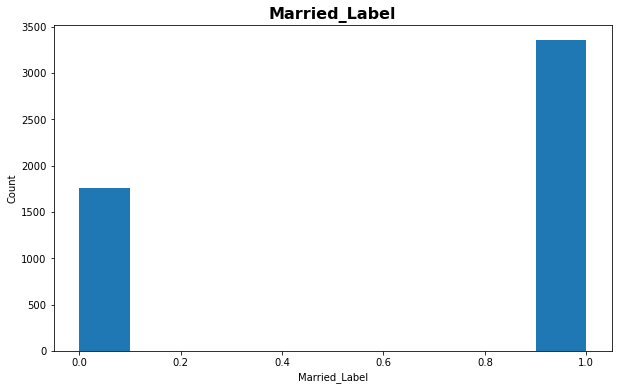

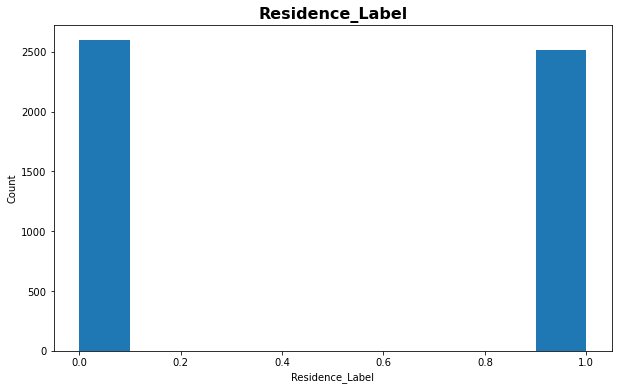

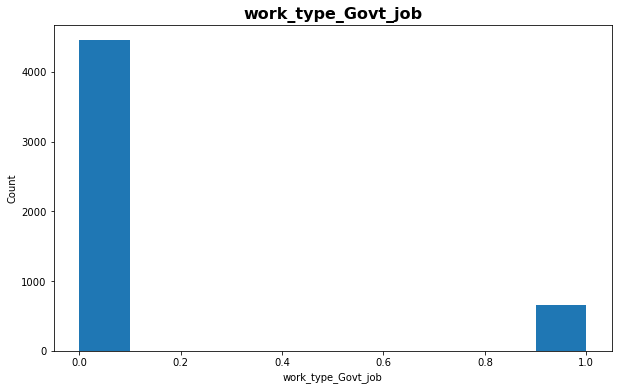

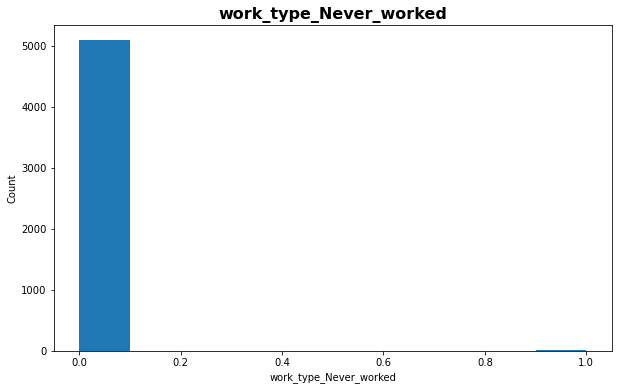

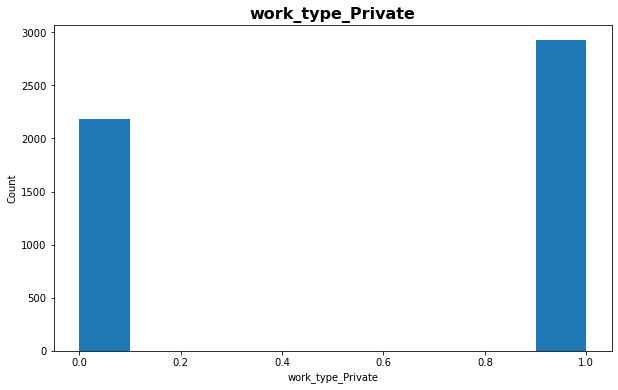

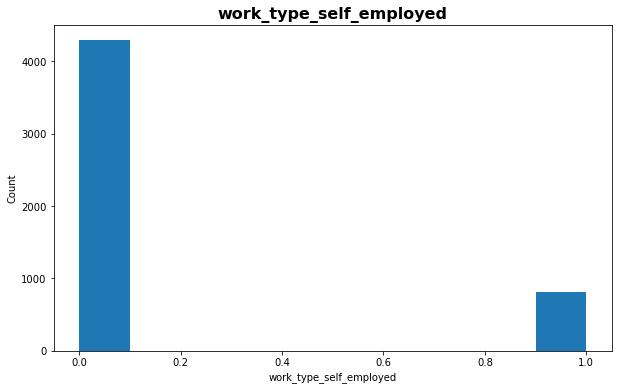

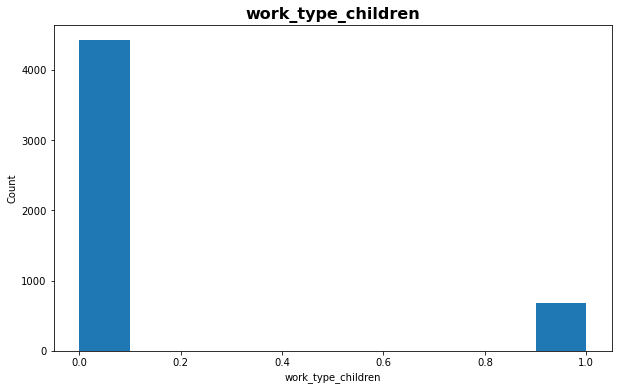

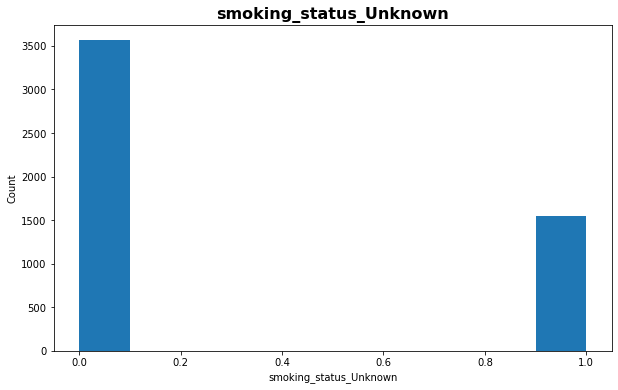

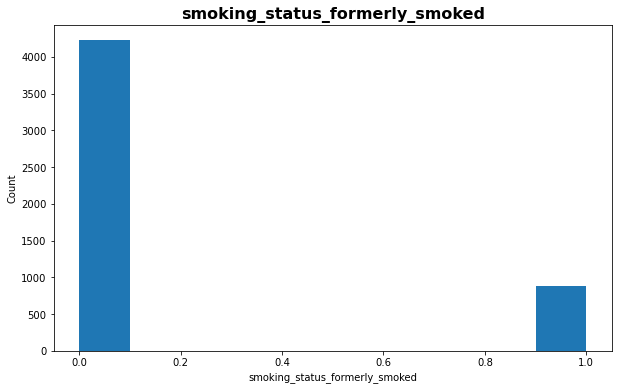

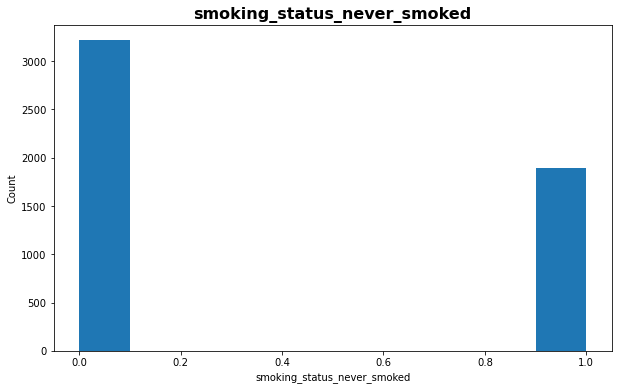

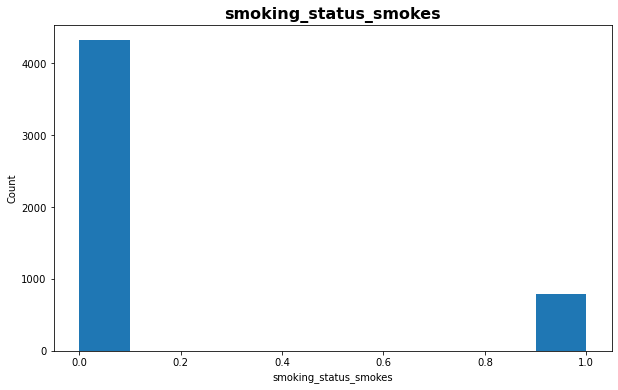

In [23]:
# Plot distributions
for col in df_train_tree.columns:
    
    plt.figure(figsize=(10,6))
    plt.hist(df_train_tree[col])
    plt.title(col, fontsize=16, fontweight="bold")
    plt.ylabel("Count")
    plt.xlabel(col)
    plt.show()

In [24]:
# Column List

#df_train_tree.columns.tolist()

In [26]:
#Resort Columns
#df_train_tree =  df_train_tree[[
#  'stroke',  
#  'age',
#  'heart_disease',
#  'avg_glucose_level', 
#  'hypertension', 
#  'Married_Label', 
#  'smoking_status_formerly_smoked',   
#  'work_type_self_employed', 
#  'bmi',
#  'work_type_Private',    
#  'Sex_Label', 
#  'smoking_status_smokes',   
#  'work_type_Govt_job', 
#  'smoking_status_never_smoked',   
#  'work_type_Never_worked',    
#  'Residence_Label',  
#  'smoking_status_Unknown',   
#  'work_type_children' 
#  ]]

## Correlations

In [28]:
df_train_tree.corr()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,Sex_Label,Married_Label,Residence_Label,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_self_employed,work_type_children,smoking_status_Unknown,smoking_status_formerly_smoked,smoking_status_never_smoked,smoking_status_smokes
age,1.000000,0.276367,0.263777,0.238323,0.325861,0.245239,-0.027752,0.679084,-0.014031,0.129965,-0.078667,0.116678,0.327949,-0.634320,-0.378366,0.237347,0.119207,0.073075
hypertension,0.276367,1.000000,0.108292,0.174540,0.160151,0.127891,0.021223,0.164187,0.007980,0.017661,-0.021612,-0.005358,0.115417,-0.129535,-0.141551,0.059022,0.065018,0.031213
heart_disease,0.263777,0.108292,1.000000,0.161907,0.038865,0.134905,0.085685,0.114601,-0.003045,0.001312,-0.015715,0.000068,0.086742,-0.091654,-0.066765,0.066938,-0.021893,0.044030
avg_glucose_level,0.238323,0.174540,0.161907,1.000000,0.168913,0.131991,0.054722,0.155329,0.004783,0.013908,-0.014665,0.016451,0.062770,-0.102195,-0.095035,0.067796,0.024011,0.017716
bmi,0.325861,0.160151,0.038865,0.168913,1.000000,0.038917,-0.025605,0.335564,0.000288,0.077885,-0.028613,0.204055,0.070757,-0.442946,-0.265094,0.104675,0.106105,0.085518
stroke,0.245239,0.127891,0.134905,0.131991,0.038917,1.000000,0.009081,0.108299,-0.015415,0.002660,-0.014885,0.011927,0.062150,-0.083888,-0.055924,0.064683,-0.004163,0.008920
Sex_Label,-0.027752,0.021223,0.085685,0.054722,-0.025605,0.009081,1.000000,-0.030171,0.006105,-0.016598,0.011486,-0.032502,-0.026045,0.089226,0.059557,0.043121,-0.098952,0.011408
Married_Label,0.679084,0.164187,0.114601,0.155329,0.335564,0.108299,-0.030171,1.000000,-0.005988,0.133964,-0.090873,0.154104,0.192637,-0.544658,-0.332335,0.171960,0.102663,0.105132
Residence_Label,-0.014031,0.007980,-0.003045,0.004783,0.000288,-0.015415,0.006105,-0.005988,1.000000,-0.013056,-0.022848,0.018005,-0.010508,0.002388,0.002167,-0.008093,0.024622,-0.027185
work_type_Govt_job,0.129965,0.017661,0.001312,0.013908,0.077885,0.002660,-0.016598,0.133964,-0.013056,1.000000,-0.025263,-0.444394,-0.167849,-0.151417,-0.097473,0.029865,0.046854,0.029994


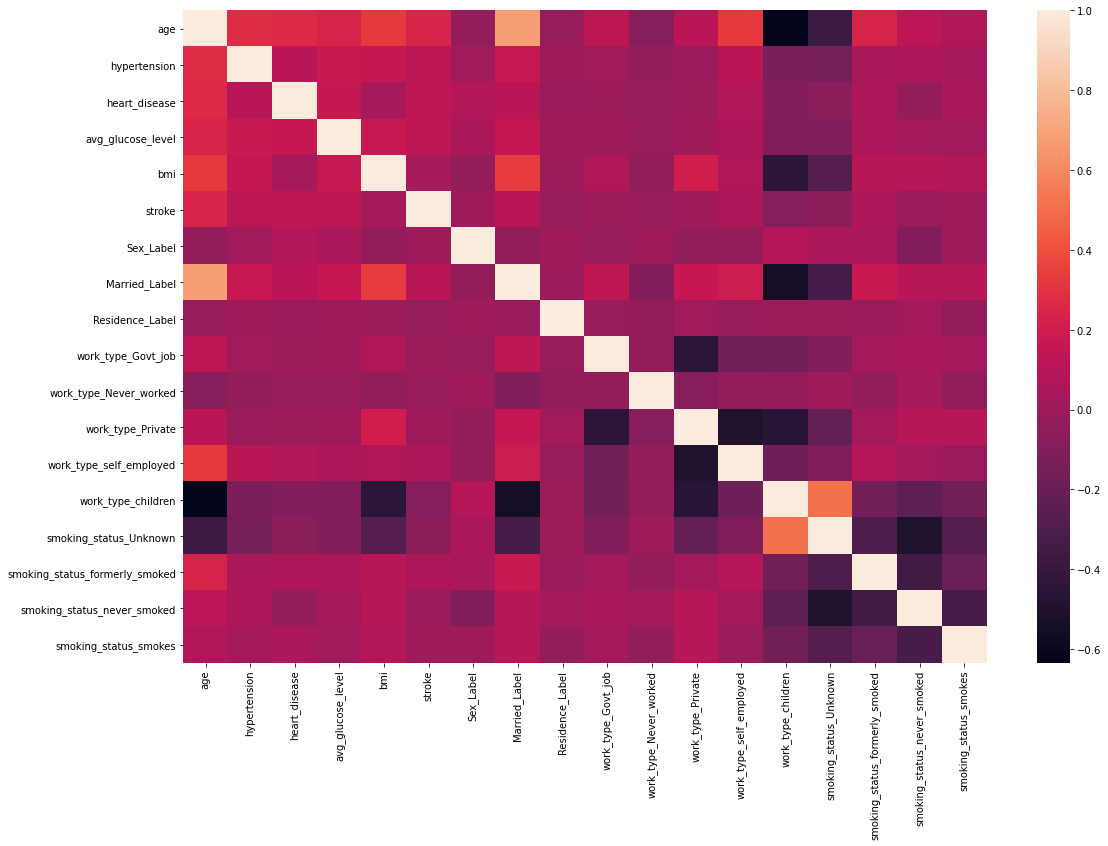

In [29]:
plt.figure(figsize=(18,12))
sns.heatmap(df_train_tree.corr())
plt.show()

## Library to fix imbalance in data set

In [30]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek,SMOTEENN

#Use counter from collections in features modeling
from collections import Counter

## Features

Before Counter({0: 3888, 1: 199})


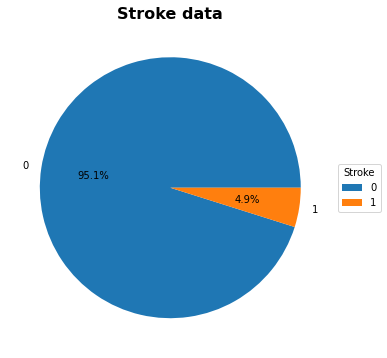

In [31]:
################################################# features
##########################################################
features = df_train_tree.drop('stroke',axis=1)
target = df_train_tree["stroke"]
X = features.to_numpy()
y = target.to_numpy()
scaler = MinMaxScaler()
X=scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2, random_state=42)
counter=Counter(y_train)
print('Before',counter)

# pie chart showing disbalnce 
##############################################
plt.figure(figsize=(10,6))
plt.pie(pd.Series(counter),autopct='%1.1f%%', labels=pd.Series(counter).index)
plt.title('Stroke data', fontsize=16, fontweight="bold")
plt.legend(pd.Series(counter).index,
          title="Stroke",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

## Synthesizing to Handle Imbalanced Class

In [32]:
#set SMOTE
#smt=SMOTETomek(random_state=42)
smt=SMOTE(random_state=42)

After Counter({0: 3888, 1: 3888})


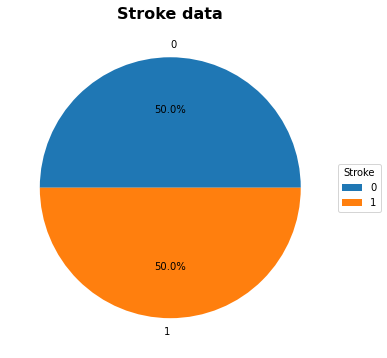

In [33]:
X_train, y_train = smt.fit_resample(X_train, y_train)

counter=Counter(y_train)
print('After',counter)

# pie chart 
plt.figure(figsize=(10,6))
plt.pie(pd.Series(counter),autopct='%1.1f%%', labels=pd.Series(counter).index)
plt.title('Stroke data', fontsize=16, fontweight="bold")
plt.legend(pd.Series(counter).index,
          title="Stroke",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

# Machine Learning

In [34]:
from sklearn.linear_model import LogisticRegression,RidgeClassifier, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve

from sklearn.model_selection import train_test_split

## Linear Models First

Model Evaluation Report
In Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.74      0.78      3888
           1       0.76      0.85      0.80      3888

    accuracy                           0.79      7776
   macro avg       0.80      0.79      0.79      7776
weighted avg       0.80      0.79      0.79      7776

In Sample Confusion Matrix: 
[[2860 1028]
 [ 580 3308]]


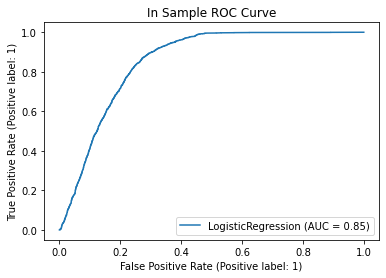


Out Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       972
           1       0.13      0.80      0.23        50

    accuracy                           0.73      1022
   macro avg       0.56      0.77      0.53      1022
weighted avg       0.94      0.73      0.81      1022

Out Sample Confusion Matrix: 
[[711 261]
 [ 10  40]]


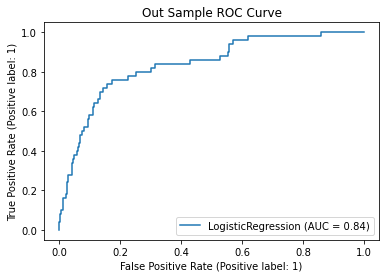

In [35]:
# initialize
log = LogisticRegression(class_weight='balanced',max_iter=1000,random_state=42)

# fit
log = log.fit(X_train, y_train)

# predictions
in_preds = log.predict(X_train)
out_preds = log.predict(X_test)

# evaluation
print("Model Evaluation Report")
print(f"In Sample Classification Report: \n{classification_report(y_train, in_preds)}")
print(f"In Sample Confusion Matrix: \n{confusion_matrix(y_train, in_preds)}")

# roc curve
plot_roc_curve(log, X_train, y_train)
plt.title("In Sample ROC Curve")
plt.show()

print()
print(f"Out Sample Classification Report: \n{classification_report(y_test, out_preds)}")
print(f"Out Sample Confusion Matrix: \n{confusion_matrix(y_test, out_preds)}")

# roc curve
plot_roc_curve(log, X_test, y_test)
plt.title("Out Sample ROC Curve")
plt.show()

Model Evaluation Report
In Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.79      0.86      3888
           1       0.82      0.96      0.88      3888

    accuracy                           0.88      7776
   macro avg       0.89      0.88      0.87      7776
weighted avg       0.89      0.88      0.87      7776

In Sample Confusion Matrix: 
[[3073  815]
 [ 156 3732]]


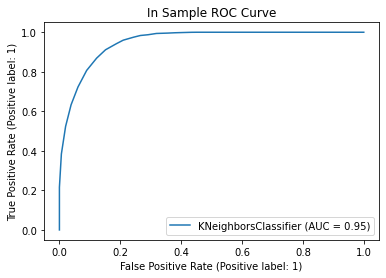


Out Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.76      0.85       972
           1       0.09      0.48      0.16        50

    accuracy                           0.75      1022
   macro avg       0.53      0.62      0.51      1022
weighted avg       0.92      0.75      0.82      1022

Out Sample Confusion Matrix: 
[[743 229]
 [ 26  24]]


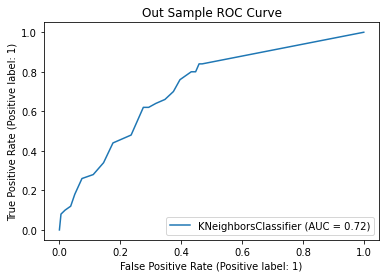

In [36]:
# initialize
knn = KNeighborsClassifier(n_neighbors=20)

# fit
knn = knn.fit(X_train, y_train)

# predictions
in_preds = knn.predict(X_train)
out_preds = knn.predict(X_test)

# evaluation
print("Model Evaluation Report")
print(f"In Sample Classification Report: \n{classification_report(y_train, in_preds)}")
print(f"In Sample Confusion Matrix: \n{confusion_matrix(y_train, in_preds)}")

# roc curve
plot_roc_curve(knn, X_train, y_train)
plt.title("In Sample ROC Curve")
plt.show()

print()
print(f"Out Sample Classification Report: \n{classification_report(y_test, out_preds)}")
print(f"Out Sample Confusion Matrix: \n{confusion_matrix(y_test, out_preds)}")

# roc curve
plot_roc_curve(knn, X_test, y_test)
plt.title("Out Sample ROC Curve")
plt.show()

Model Evaluation Report
In Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.81      0.87      3888
           1       0.83      0.94      0.88      3888

    accuracy                           0.88      7776
   macro avg       0.88      0.88      0.88      7776
weighted avg       0.88      0.88      0.88      7776

In Sample Confusion Matrix: 
[[3146  742]
 [ 216 3672]]


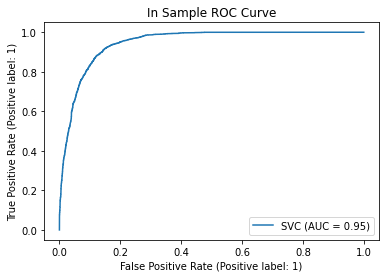


Out Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.79      0.87       972
           1       0.12      0.54      0.19        50

    accuracy                           0.78      1022
   macro avg       0.55      0.67      0.53      1022
weighted avg       0.93      0.78      0.84      1022

Out Sample Confusion Matrix: 
[[772 200]
 [ 23  27]]


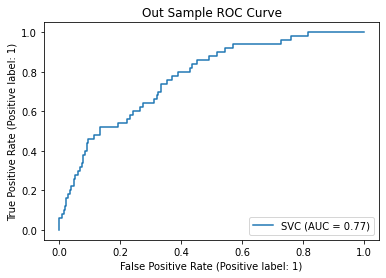

In [37]:
# initialize
svm = SVC(class_weight='balanced')

# fit
svm = svm.fit(X_train, y_train)

# predictions
in_preds = svm.predict(X_train)
out_preds = svm.predict(X_test)

# evaluation
print("Model Evaluation Report")
print(f"In Sample Classification Report: \n{classification_report(y_train, in_preds)}")
print(f"In Sample Confusion Matrix: \n{confusion_matrix(y_train, in_preds)}")

# roc curve
plot_roc_curve(svm, X_train, y_train)
plt.title("In Sample ROC Curve")
plt.show()

print()
print(f"Out Sample Classification Report: \n{classification_report(y_test, out_preds)}")
print(f"Out Sample Confusion Matrix: \n{confusion_matrix(y_test, out_preds)}")

# roc curve
plot_roc_curve(svm, X_test, y_test)
plt.title("Out Sample ROC Curve")
plt.show()

## Trees

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier


Model Evaluation Report
In Sample Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3888
           1       1.00      1.00      1.00      3888

    accuracy                           1.00      7776
   macro avg       1.00      1.00      1.00      7776
weighted avg       1.00      1.00      1.00      7776

In Sample Confusion Matrix: 
[[3888    0]
 [   0 3888]]


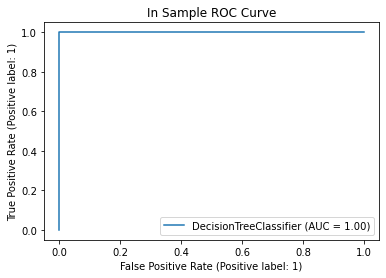


Out Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       972
           1       0.10      0.18      0.13        50

    accuracy                           0.88      1022
   macro avg       0.53      0.55      0.54      1022
weighted avg       0.91      0.88      0.90      1022

Out Sample Confusion Matrix: 
[[895  77]
 [ 41   9]]


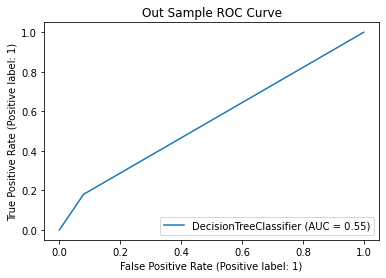

In [39]:
# initialize
dt = DecisionTreeClassifier(random_state=42)

# fit
dt = dt.fit(X_train, y_train)

# predictions
in_preds = dt.predict(X_train)
out_preds = dt.predict(X_test)

# evaluation
print("Model Evaluation Report")
print(f"In Sample Classification Report: \n{classification_report(y_train, in_preds)}")
print(f"In Sample Confusion Matrix: \n{confusion_matrix(y_train, in_preds)}")

# roc curve
plot_roc_curve(dt, X_train, y_train)
plt.title("In Sample ROC Curve")
plt.show()

print()
print(f"Out Sample Classification Report: \n{classification_report(y_test, out_preds)}")
print(f"Out Sample Confusion Matrix: \n{confusion_matrix(y_test, out_preds)}")

# roc curve
plot_roc_curve(dt, X_test, y_test)
plt.title("Out Sample ROC Curve")
plt.show()

Model Evaluation Report
In Sample Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3888
           1       1.00      1.00      1.00      3888

    accuracy                           1.00      7776
   macro avg       1.00      1.00      1.00      7776
weighted avg       1.00      1.00      1.00      7776

In Sample Confusion Matrix: 
[[3888    0]
 [   0 3888]]


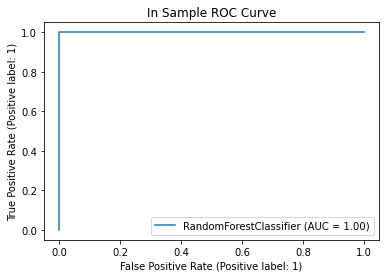


Out Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       972
           1       0.14      0.18      0.16        50

    accuracy                           0.91      1022
   macro avg       0.55      0.56      0.56      1022
weighted avg       0.92      0.91      0.91      1022

Out Sample Confusion Matrix: 
[[918  54]
 [ 41   9]]


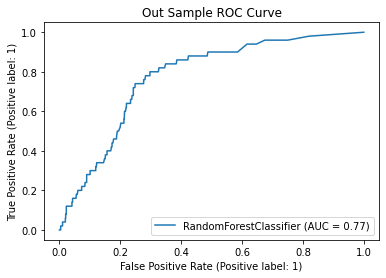

In [40]:
# initialize
rf = RandomForestClassifier(random_state=42,n_estimators= 1000)

# fit
rf = rf.fit(X_train, y_train)

# predictions
in_preds = rf.predict(X_train)
out_preds = rf.predict(X_test)

# evaluation
print("Model Evaluation Report")
print(f"In Sample Classification Report: \n{classification_report(y_train, in_preds)}")
print(f"In Sample Confusion Matrix: \n{confusion_matrix(y_train, in_preds)}")

# roc curve
plot_roc_curve(rf, X_train, y_train)
plt.title("In Sample ROC Curve")
plt.show()

print()
print(f"Out Sample Classification Report: \n{classification_report(y_test, out_preds)}")
print(f"Out Sample Confusion Matrix: \n{confusion_matrix(y_test, out_preds)}")

# roc curve
plot_roc_curve(rf, X_test, y_test)
plt.title("Out Sample ROC Curve")
plt.show()

Model Evaluation Report
In Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      3888
           1       0.94      0.93      0.94      3888

    accuracy                           0.94      7776
   macro avg       0.94      0.94      0.94      7776
weighted avg       0.94      0.94      0.94      7776

In Sample Confusion Matrix: 
[[3639  249]
 [ 253 3635]]


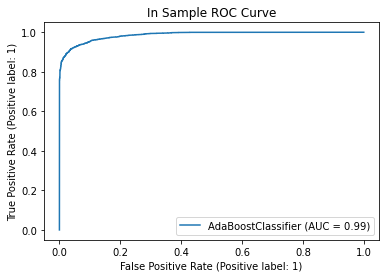


Out Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       972
           1       0.20      0.30      0.24        50

    accuracy                           0.91      1022
   macro avg       0.58      0.62      0.60      1022
weighted avg       0.93      0.91      0.92      1022

Out Sample Confusion Matrix: 
[[912  60]
 [ 35  15]]


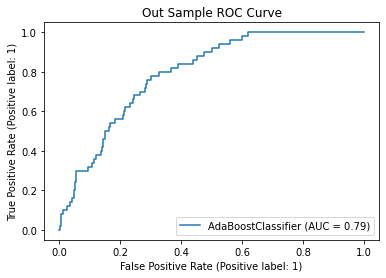

In [41]:
# initialize
ada = AdaBoostClassifier(random_state=42,n_estimators= 1000)

# fit
ada = ada.fit(X_train, y_train)

# predictions
in_preds = ada.predict(X_train)
out_preds = ada.predict(X_test)

# evaluation
print("Model Evaluation Report")
print(f"In Sample Classification Report: \n{classification_report(y_train, in_preds)}")
print(f"In Sample Confusion Matrix: \n{confusion_matrix(y_train, in_preds)}")

# roc curve
plot_roc_curve(ada, X_train, y_train)
plt.title("In Sample ROC Curve")
plt.show()

print()
print(f"Out Sample Classification Report: \n{classification_report(y_test, out_preds)}")
print(f"Out Sample Confusion Matrix: \n{confusion_matrix(y_test, out_preds)}")

# roc curve
plot_roc_curve(ada, X_test, y_test)
plt.title("Out Sample ROC Curve")
plt.show()

Model Evaluation Report
In Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3888
           1       1.00      0.99      0.99      3888

    accuracy                           0.99      7776
   macro avg       0.99      0.99      0.99      7776
weighted avg       0.99      0.99      0.99      7776

In Sample Confusion Matrix: 
[[3886    2]
 [  51 3837]]


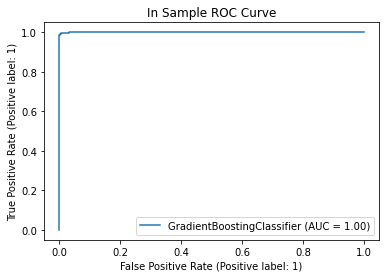


Out Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       972
           1       0.36      0.20      0.26        50

    accuracy                           0.94      1022
   macro avg       0.66      0.59      0.61      1022
weighted avg       0.93      0.94      0.94      1022

Out Sample Confusion Matrix: 
[[954  18]
 [ 40  10]]


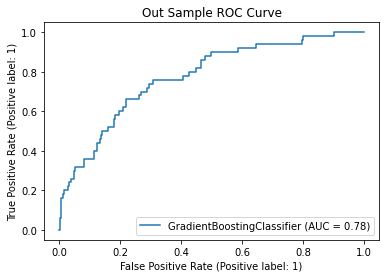

In [42]:
# initialize
gb = GradientBoostingClassifier(random_state=42,n_estimators= 1000)

# fit
gb = gb.fit(X_train, y_train)

# predictions
in_preds = gb.predict(X_train)
out_preds = gb.predict(X_test)

# evaluation
print("Model Evaluation Report")
print(f"In Sample Classification Report: \n{classification_report(y_train, in_preds)}")
print(f"In Sample Confusion Matrix: \n{confusion_matrix(y_train, in_preds)}")

# roc curve
plot_roc_curve(gb, X_train, y_train)
plt.title("In Sample ROC Curve")
plt.show()

print()
print(f"Out Sample Classification Report: \n{classification_report(y_test, out_preds)}")
print(f"Out Sample Confusion Matrix: \n{confusion_matrix(y_test, out_preds)}")

# roc curve
plot_roc_curve(gb, X_test, y_test)
plt.title("Out Sample ROC Curve")
plt.show()

In [43]:
from xgboost import XGBClassifier

[19:03:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Evaluation Report
In Sample Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3888
           1       1.00      1.00      1.00      3888

    accuracy                           1.00      7776
   macro avg       1.00      1.00      1.00      7776
weighted avg       1.00      1.00      1.00      7776

In Sample Confusion Matrix: 
[[3887    1]
 [  13 3875]]


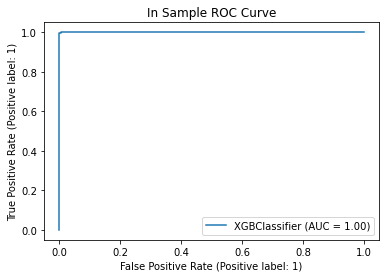


Out Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       972
           1       0.17      0.12      0.14        50

    accuracy                           0.93      1022
   macro avg       0.56      0.55      0.55      1022
weighted avg       0.92      0.93      0.92      1022

Out Sample Confusion Matrix: 
[[943  29]
 [ 44   6]]


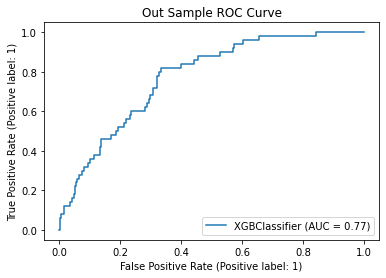

In [44]:
# initialize
xgb = XGBClassifier(use_label_encoder=False,random_state=42)

#xgb = XGBClassifier(use_label_encoder=False,eval_metric='error',learning_rate=0.07, num_iterations=1000)

# fit
xgb = xgb.fit(X_train, y_train)

# predictions
in_preds = xgb.predict(X_train)
out_preds = xgb.predict(X_test)

# evaluation
print("Model Evaluation Report")
print(f"In Sample Classification Report: \n{classification_report(y_train, in_preds)}")
print(f"In Sample Confusion Matrix: \n{confusion_matrix(y_train, in_preds)}")

# roc curve
plot_roc_curve(xgb, X_train, y_train)
plt.title("In Sample ROC Curve")
plt.show()

print()
print(f"Out Sample Classification Report: \n{classification_report(y_test, out_preds)}")
print(f"Out Sample Confusion Matrix: \n{confusion_matrix(y_test, out_preds)}")

# roc curve
plot_roc_curve(xgb, X_test, y_test)
plt.title("Out Sample ROC Curve")
plt.show()

# Model Selection

In [45]:
# We choose Logistic Regression because of the high recall rate for predicted actual strokes vs other models

Model Evaluation Report
In Sample Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.74      0.84      4860
           1       0.14      0.82      0.24       249

    accuracy                           0.74      5109
   macro avg       0.56      0.78      0.54      5109
weighted avg       0.95      0.74      0.81      5109

In Sample Confusion Matrix: 
[[3581 1279]
 [  45  204]]



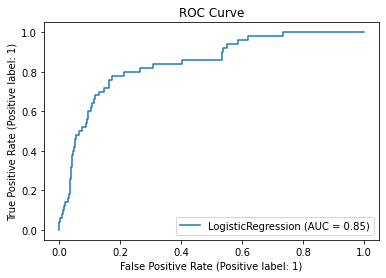

In [46]:
#initialize
log_final = LogisticRegression(class_weight='balanced',max_iter=1000, random_state=42)


# fit
log_final.fit(X, y)

# predict
in_preds = log_final.predict(X)

#evaluate
print("Model Evaluation Report")
print(f"In Sample Classification Report: \n{classification_report(y, in_preds)}")
print(f"In Sample Confusion Matrix: \n{confusion_matrix(y, in_preds)}")
print()

# roc curve
plot_roc_curve(log_final, X_test, y_test)
plt.title("ROC Curve")
plt.show()

# Create Submission

In [47]:
# Read in data to predict
# from the 2nd cell above, don't have a test.csv, df = pd.read_csv("healthcare-dataset-stroke-data.csv")
# df_test = pd.read_csv("test.csv")
df_test = pd.read_csv("../Resources/healthcare-dataset-stroke-data.csv")
df_test.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [48]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [49]:
# impute Nulls with mean/mode  
df_test.bmi.fillna(df.bmi.mean(), inplace=True)
    

In [50]:
#Save df_test to .csv to capture imputed BMI data for dashboards

df_test.to_csv('../Resources/healthcare-dataset-stroke-data_imputed_bmi.csv', index=False)

In [51]:
# drop record
# Delete 1 "other" gender
df_test = df_test.loc[df_test["gender"] != "Other"]

df_test.shape

(5109, 12)

In [52]:
# manipulate columns 2
    # Substitute 1/0 for yes / no and rural / urban 

df_test["Sex_Label"] = [1 if x == "Male" else 0 for x in df_test.gender] #label encoding
df_test.drop("gender", axis=1, inplace=True)

df_test["Married_Label"] = [1 if x == "Yes" else 0 for x in df_test.ever_married] #label encoding
df_test.drop("ever_married", axis=1, inplace=True)

df_test["Residence_Label"] = [1 if x == "Rural" else 0 for x in df_test.Residence_type] #label encoding
df_test.drop("Residence_type", axis=1, inplace=True)

In [53]:
df_test

,id,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,smoking_status,stroke,Sex_Label,Married_Label,Residence_Label
0,9046,67.0,0,1,Private,228.69,36.60000,formerly smoked,1,1,1,0
1,51676,61.0,0,0,Self-employed,202.21,28.89456,never smoked,1,0,1,1
2,31112,80.0,0,1,Private,105.92,32.50000,never smoked,1,1,1,1
3,60182,49.0,0,0,Private,171.23,34.40000,smokes,1,0,1,0
4,1665,79.0,1,0,Self-employed,174.12,24.00000,never smoked,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,80.0,1,0,Private,83.75,28.89456,never smoked,0,0,1,0
5106,44873,81.0,0,0,Self-employed,125.20,40.00000,never smoked,0,0,1,0
5107,19723,35.0,0,0,Self-employed,82.99,30.60000,never smoked,0,0,1,1
5108,37544,51.0,0,0,Private,166.29,25.60000,formerly smoked,0,1,1,1


In [54]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5109 non-null   int64  
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   work_type          5109 non-null   object 
 5   avg_glucose_level  5109 non-null   float64
 6   bmi                5109 non-null   float64
 7   smoking_status     5109 non-null   object 
 8   stroke             5109 non-null   int64  
 9   Sex_Label          5109 non-null   int64  
 10  Married_Label      5109 non-null   int64  
 11  Residence_Label    5109 non-null   int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 518.9+ KB


In [55]:
# Cast category to string - get dummies
tree_dums_test = pd.get_dummies(df_test[["work_type", "smoking_status"]], drop_first=False)
tree_dums_test

,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0,0,1,0,0,0,1,0,0
1,0,0,0,1,0,0,0,1,0
2,0,0,1,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,1
4,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
5105,0,0,1,0,0,0,0,1,0
5106,0,0,0,1,0,0,0,1,0
5107,0,0,0,1,0,0,0,1,0
5108,0,0,1,0,0,0,1,0,0


In [56]:
# Combine back into the testing set
df_test_tree = pd.concat([df_test[["age", "hypertension", "heart_disease", "avg_glucose_level", "bmi", "Sex_Label","Married_Label","Residence_Label"]], tree_dums_test], axis=1)
df_test_tree

,age,hypertension,heart_disease,avg_glucose_level,bmi,Sex_Label,Married_Label,Residence_Label,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.60000,1,1,0,0,0,1,0,0,0,1,0,0
1,61.0,0,0,202.21,28.89456,0,1,1,0,0,0,1,0,0,0,1,0
2,80.0,0,1,105.92,32.50000,1,1,1,0,0,1,0,0,0,0,1,0
3,49.0,0,0,171.23,34.40000,0,1,0,0,0,1,0,0,0,0,0,1
4,79.0,1,0,174.12,24.00000,0,1,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,80.0,1,0,83.75,28.89456,0,1,0,0,0,1,0,0,0,0,1,0
5106,81.0,0,0,125.20,40.00000,0,1,0,0,0,0,1,0,0,0,1,0
5107,35.0,0,0,82.99,30.60000,0,1,1,0,0,0,1,0,0,0,1,0
5108,51.0,0,0,166.29,25.60000,1,1,1,0,0,1,0,0,0,1,0,0


## Final Data Cleanup

In [58]:
# convert work types from uint8 to integer
df_test_tree = df_test_tree.astype({"work_type_Govt_job": int, "work_type_Never_worked": int, "work_type_Private": int, "work_type_Self-employed": int, "work_type_children": int, "smoking_status_Unknown": int, "smoking_status_formerly smoked": int, "smoking_status_never smoked": int, "smoking_status_smokes": int})

In [59]:
# rename fields with bad syntax
df_test_tree = df_test_tree.rename({'work_type_Self-employed': 'work_type_self_employed', 'smoking_status_formerly smoked': 'smoking_status_formerly_smoked', 'smoking_status_never smoked':'smoking_status_never_smoked'}, axis=1)

In [60]:
df_test_tree.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5109 non-null   float64
 1   hypertension                    5109 non-null   int64  
 2   heart_disease                   5109 non-null   int64  
 3   avg_glucose_level               5109 non-null   float64
 4   bmi                             5109 non-null   float64
 5   Sex_Label                       5109 non-null   int64  
 6   Married_Label                   5109 non-null   int64  
 7   Residence_Label                 5109 non-null   int64  
 8   work_type_Govt_job              5109 non-null   int32  
 9   work_type_Never_worked          5109 non-null   int32  
 10  work_type_Private               5109 non-null   int32  
 11  work_type_self_employed         5109 non-null   int32  
 12  work_type_children              51

In [64]:
df_test_tree

,age,hypertension,heart_disease,avg_glucose_level,bmi,Sex_Label,Married_Label,Residence_Label,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_self_employed,work_type_children,smoking_status_Unknown,smoking_status_formerly_smoked,smoking_status_never_smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.60000,1,1,0,0,0,1,0,0,0,1,0,0
1,61.0,0,0,202.21,28.89456,0,1,1,0,0,0,1,0,0,0,1,0
2,80.0,0,1,105.92,32.50000,1,1,1,0,0,1,0,0,0,0,1,0
3,49.0,0,0,171.23,34.40000,0,1,0,0,0,1,0,0,0,0,0,1
4,79.0,1,0,174.12,24.00000,0,1,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,80.0,1,0,83.75,28.89456,0,1,0,0,0,1,0,0,0,0,1,0
5106,81.0,0,0,125.20,40.00000,0,1,0,0,0,0,1,0,0,0,1,0
5107,35.0,0,0,82.99,30.60000,0,1,1,0,0,0,1,0,0,0,1,0
5108,51.0,0,0,166.29,25.60000,1,1,1,0,0,1,0,0,0,1,0,0


In [62]:
# convert to list and then predict
X_test_data = df_test_tree.to_numpy()

In [63]:
# command for yes/no response test_preds = log_final.predict(X_test_data)

test_preds = log_final.predict_proba(X_test_data)[:, 1]

#temporarily set threshold to max to see entire array
with np.printoptions(threshold=np.inf):
    print(test_preds)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [ ]:
final_sub = pd.DataFrame()
final_sub["id"] = df_test.id
final_sub["stroke"] = test_preds

In [ ]:
final_sub

In [ ]:
final_sub.to_csv("submission.csv", index=False)

In [ ]:
import pickle

In [ ]:
# save model to disk
filename = '../finalized_model.sav'
pickle.dump(log_final, open(filename, 'wb'))

In [ ]:
#my_new_model = pickle.load(filename)

# Feature importance

In [ ]:
# Feature Importance - not available for logistics regression
#feat_imps = pd.DataFrame(list(zip(features.columns, log_final.feature_importances_)), columns=["Feature", "Importance"])
#feat_imps_sort = feat_imps.sort_values(by="Importance", ascending=False).reset_index(drop=True)
#feat_imps_sort

In [ ]:
#Not available for linear regression

#plt.figure(figsize=(14,8))
#plt.bar(feat_imps_sort.Feature, feat_imps_sort.Importance)
#plt.title("Feature Importances")
#plt.xticks(rotation=45)
#plt.show()

## For After

In [ ]:
new_pred = rf.predict_proba([X_test[0]])
new_pred

In [ ]:
len(X[0])